In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from helper_functions import print_boxed_text
from cluster_comparison import  drop_na_values, perform_umap, perform_hdbscan, calculate_silhouette, plot_clusters
from skopt import gp_minimize
from skopt.space import Real, Integer
from functools import partial

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d

In [2]:
# Sample data and demographics DataFrames, replace these with your actual DataFrames
raw_data = pd.read_csv('/Users/leo/Programming/PLR/Leo/data/cleaned_data_SYMPTOMS_9_13_23_DNA.csv')
data_symp_groups = pd.read_csv('data/skew_corr_groupadd.csv', usecols=['Grouped_Neuro_Sensory', 'Grouped_Cognitive_Memory', 'Grouped_Gastrointestinal', 'Grouped_Respiratory_Cardiac', 'Grouped_Eye_Vision'])
data_symp_groups_all = pd.read_csv('data/skew_corr_groupadd.csv')
demographics = pd.read_csv('/Users/leo/Programming/PLR/Leo/data/non_binary_data_processed.csv')

# combine demographics and data_symp_group_all 
demo_all = pd.concat([demographics, data_symp_groups_all], axis=1)

# combine demographics and data_symp_group
demo_groups = pd.concat([demographics, data_symp_groups], axis=1)

In [3]:
# Count the number of NaNs in each column
nan_count_data = data_symp_groups_all.isna().sum()
nan_count_demographics = demographics.isna().sum()

# Print boxed text with NaN information
print_boxed_text(
    [
        "Missing Values Report",
        f"Data DataFrame: {nan_count_data.sum()} NaNs",
        f"Demographics DataFrame: {nan_count_demographics.sum()} NaNs",
    ],
    is_title=[True, False, False],
)

# Find indices of rows with NaNs in 'demographics'
nan_indices = demographics[demographics.isna().any(axis=1)].index

# Report the operation
print_boxed_text([
    "Handling NaNs in the DataFrame",
    "Due to NaNs in the 'demographics' DataFrame, we are also dropping the corresponding rows in the 'data' DataFrame."
], [True, False])

# Drop these indices from both DataFrames
condition = demographics.isna().any(axis=1)
data_symp_groups_all = data_symp_groups_all.loc[~condition]
demographics = demographics.dropna()


# Target and feature dataframes
grouped_symptoms = ['Grouped_Neuro_Sensory', 'Grouped_Cognitive_Memory', 'Grouped_Gastrointestinal', 
                    'Grouped_Respiratory_Cardiac', 'Grouped_Eye_Vision']
y = data_symp_groups_all[grouped_symptoms]
X = demographics

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

┌────────────────────────────────┐
├────────────────────────────────┤
│     Missing Values Report      │
├────────────────────────────────┤
│                                │
│ Data DataFrame: 0 NaNs         │
│ Demographics DataFrame: 0 NaNs │
└────────────────────────────────┘
┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                           Handling NaNs in the DataFrame                                          │
├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                                                   │
│ Due to NaNs in the 'demographics' DataFrame, we are also dropping the corresponding rows in the 'data' DataFrame. │
└───────────

┌───────────────────────────────────┐
├───────────────────────────────────┤
│     Model Performance Metrics     │
├───────────────────────────────────┤
│                                   │
│ OOB Score: 0.6206793802145412     │
│ Hamming Loss: 0.2826190476190476  │
│ Mean Accuracy: 0.1988095238095238 │
└───────────────────────────────────┘


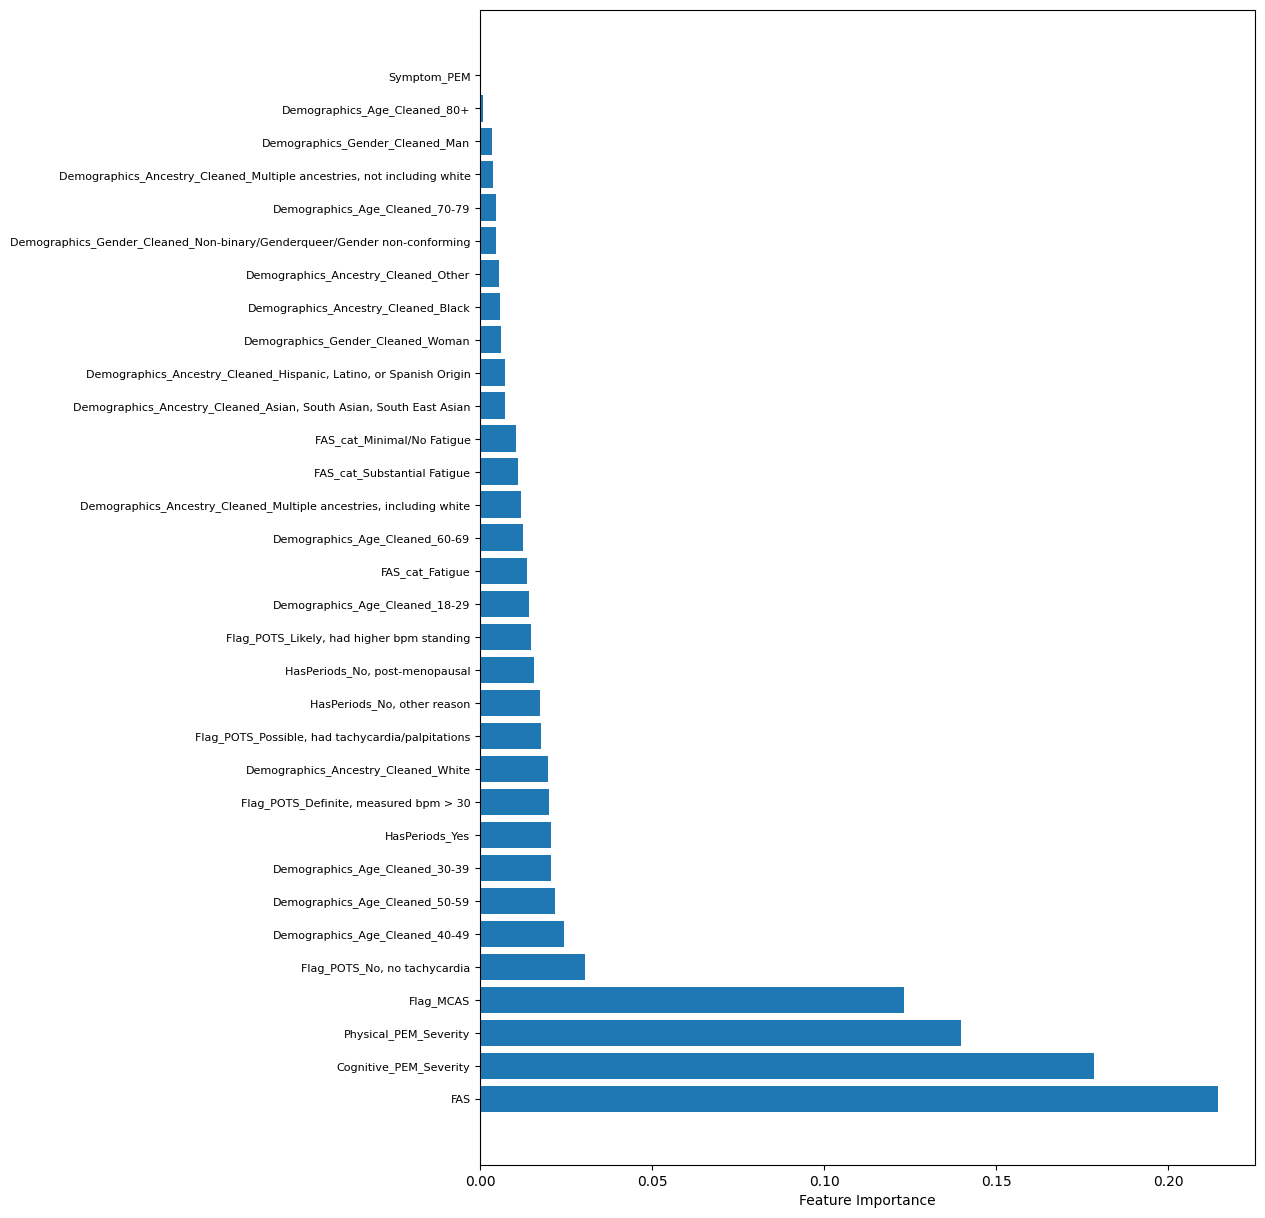

In [4]:
# Initialize and train the RandomForest model
base_rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
model = MultiOutputClassifier(base_rf, n_jobs=-1)
model.fit(X_train, y_train)

# Mean Accuracy on the test set
mean_accuracy = model.score(X_test, y_test)

# Prediction on the test set
y_pred = model.predict(X_test)

# Hamming Loss
hamming = hamming_loss(y_test, y_pred)

# Use print_boxed_text to show Hamming Loss and Mean Accuracy
print_boxed_text(
    [
        "Model Performance Metrics",
        f"OOB Score: {model.estimators_[0].oob_score_}",
        f"Hamming Loss: {hamming}",
        f"Mean Accuracy: {mean_accuracy}"
    ],
    is_title=[True, False, False, False]
)

# Feature Importances sorted
plt.figure(figsize=(10, 15))  # Make the plot bigger
feature_importances = model.estimators_[0].feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]  # Sort in descending order

plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx], fontsize=8)  # Rotate labels and adjust font size
plt.xlabel('Feature Importance')
plt.show()
